<a href="https://colab.research.google.com/github/BR-Lab/ML-algorithm/blob/main/KNN_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN 실습

## 0.Introduction

<분석 모델>
*  데이터 전처리
*  KNN model들 구축(hyperparameter 탐색)
   * k-fold cross validation 활용해 K & distance 선정
*  예측 결과 평가(k-fold validation) & weighted KNN 구축

<분석 데이터>
*  유방암 진단결과 data

## 1.import module

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action = 'ignore')

# 데이터 로드
from sklearn.datasets import load_breast_cancer

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm

from sklearn.model_selection import KFold
from scipy.stats import spearmanr

#데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

#한글 폰트 설정
plt.rc('font', family = 'Malgun Gothic')

## 2.데이터 불러오기 & 분석 및 전처리

###2.1 data description

<데이터 구조>


*   데이터 : 유방암 진단결과
*   관측치 개수: 569개
*   변수 개수: 32개(설명변수: 30개, 반응변수: 1개(1(양성),0(음성)), ID)


In [ ]:
# load data
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [ ]:
breast_cancer.data.shape

(569, 30)

##3 탐색적 데이터 분석 & 데이터 전처리

In [ ]:
# 데이터 프레임 형태로 변환
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y.tail()

,diagnosis
564,0
565,0
566,0
567,0
568,1


###3.1 결측치, 데이터 타입 확인

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
y['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

###3.2 Train/Test 데이터 분리

*  Train 70%, Test 30%로 나누기

In [ ]:
# train, test data 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2021)

# 데이터 컬럼 단위 정규화
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f"Train set dimension is {X_train.shape}")
print(f"Test set dimension is {X_test.shape}")

Train set dimension is (398, 30)
Test set dimension is (171, 30)


##4.모델링


*   K 개수 결정
*   Distance measure 결정





###4.1 K에 따른 결과



*   K가 매우 작을 경우: 데이터의 지역적 특성을 지나치게 반영(overfitting)
*   K가 매우 클 경우: 다른 범주의 개체를 너무 만히 포함하여 오분류할 위험(underfitting)



findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


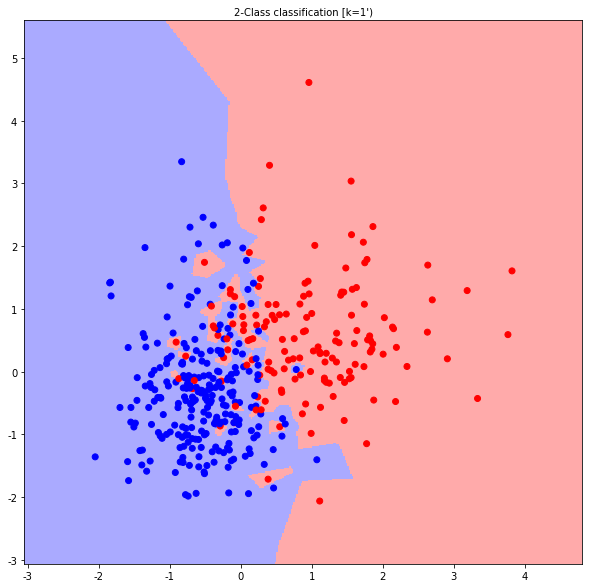

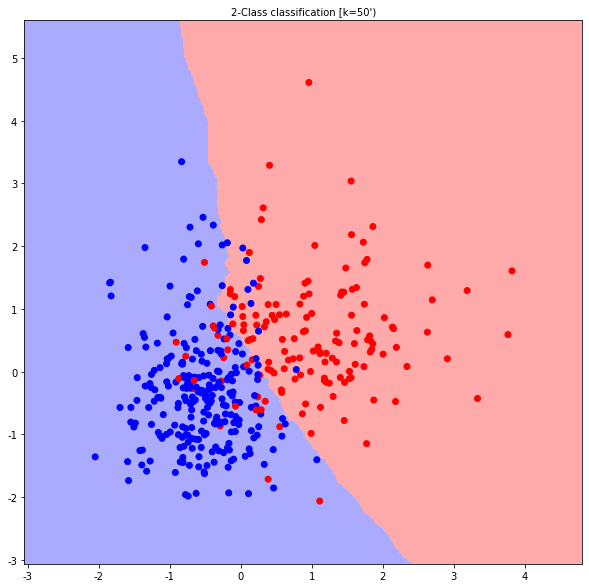

In [ ]:
X_vis = X_train[:, :2] #시각화를 위해 임의로 2개의 feature활용
y_vis = y_train.values.ravel()

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in [1, 50]:
  clf = KNeighborsClassifier(n_neighbors= k)
  clf.fit(X_vis, y_vis)

  # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max]
  x_min, x_max = X_vis[:, 0].min()-1, X_vis[:, 0].max()+1
  y_min, y_max = X_vis[:, 1].min()-1, X_vis[:, 1].max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(10,10))
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # Plot size the training points
  plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap=cmap_bold)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title(f"2-Class classification [k={k}')", fontsize=10)

plt.show()

###4.1 Hyperparameter K 결정

In [ ]:
k_list = [i for i in range(1,100) if i%2 != 0]
cv_scores = []

for k in tqdm(k_list) :
  classifier = KNeighborsClassifier(n_neighbors= k, p=2)

  scores = cross_val_score(classifier, X_train, y_train, cv = 10, scoring='accuracy')
  cv_scores.append(scores.mean())

100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


In [ ]:
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value: ", best_k)

Best k value:  [5]


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


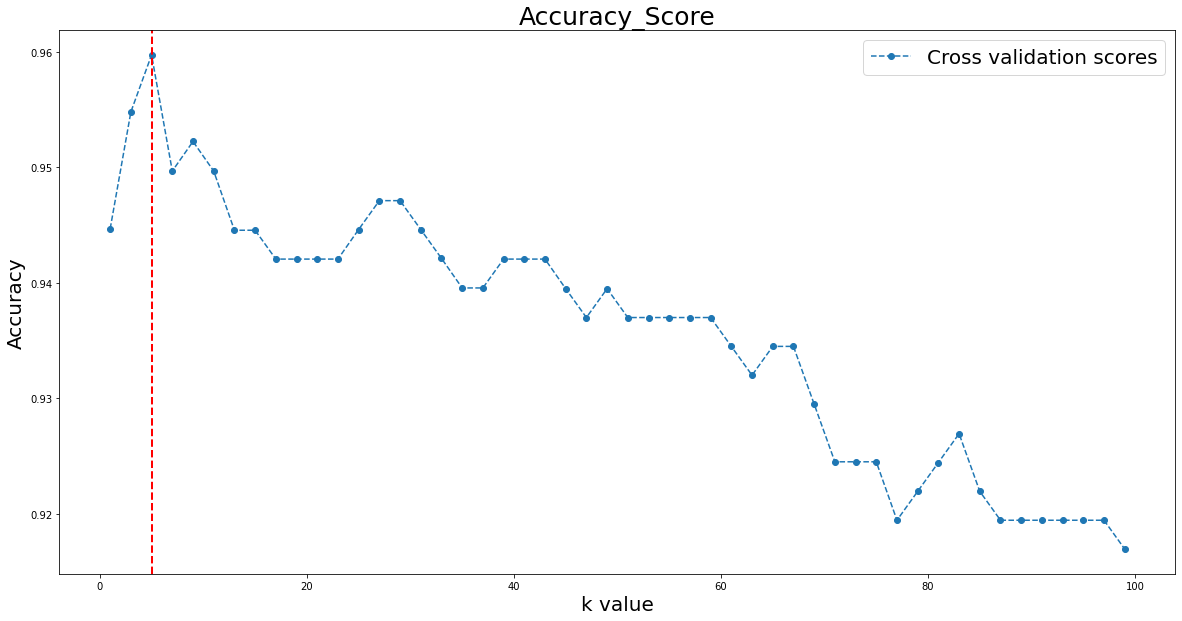

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel("k value", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy_Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)

plt.show()

###4.2 Distance Type 결정



1.   Euclidean Distance
2.   Manhattan Distance
3.   항목 추가
4.   항목 추가





####4.2.1 Euclidean Distance



*   가장 흔히 사용되는 거리축도
*   대응되는 x, y값 간 차이 제곱합의 제곱근

$$d_(X,Y)=\sqrt{\sum_{i=1}^{n}(x_i-y_i)^2}$$



In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0 ]

euc = []
for k in tqdm(k_list) :
  classifier = KNeighborsClassifier(n_neighbors= k, p=2)
  scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
  euc.append(scores.mean())

100%|██████████| 50/50 [00:03<00:00, 15.57it/s]


####4.2.2 Mangattan Distance



*   x에서 y로 이동 시 각 좌표축 방향으로만 이동할 경우에 계산되는 거리

$$d_{Manhattan(X,Y)}=\sum_{i=1}^{n}|x_i-y_i|$$



In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0]

man = []
for k in tqdm(k_list):
  classifier = KNeighborsClassifier(n_neighbors=k, p=1)
  scores = cross_val_score(classifier, X_train, y_train, cv = 10, scoring='accuracy')
  man.append(scores.mean())

100%|██████████| 50/50 [00:03<00:00, 15.81it/s]


####4.2.3 Mahalanobis Distance


*   변수 내 분산, 변수 간 공분산을 모두 반영하여 x, y 간의 거리를 계산
*   데이터의 covariance matrix가 identity matrix인 경우는 Euclidean distance와 동일

$$d_{Manhattan(X,Y)}=\sqrt{(X-Y)^T\sum-1(X-Y)},$$
$$\sum-1 :inverse\,\, of\,\, covariance\,\, matrix$$



In [ ]:
y_train = y_train.values.ravel()
Kf = KFold(n_splits=10)
Kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2  != 0]
mah = []

for k in tqdm(k_list):
  mah_acc = []
  for train_index, valid_index in Kf.split(X_train):
    X_train_f = X_train[train_index]
    y_train_f = y_train[train_index]

    X_valid_f = X_train[valid_index]
    y_valid_f = y_train[valid_index]

    total = len(y_valid_f)
    correct = 0

    nn = NearestNeighbors(algorithm='brute', metric='mahalanobis',
                          metric_params={'V': np.cov(X_train_f, rowvar=False)}, n_neighbors=k)
    nn_model = nn.fit(X_train_f, y_train_f)

    for v in range(len(X_valid_f)):
      distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

      class_list = {'0':0, '1':0}
      for i in range(len(indices[0])):
        if y_train_f[indices[0][i]] == 0:
          class_list['0'] += 1
        else:
          class_list['1'] += 1

      max_key = np.int(max(class_list, key= class_list.get))
      if max_key == y_valid_f[v]:
        correct += 1

    mah_acc.append(correct/total)

  mah.append(np.mean(mah_acc))

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


####4.2.4 Correlation Distance


*   데이터간 Pearson correalation을 거리측도로 사요하는 방식. 데이터 패턴의 유사도를 반영할 수 있음

$$d_{Corr(X,Y)}=1-r$$
$$where\,\, r=\sigma_{XY}$$



In [ ]:
Kf = KFold(n_splits=10)
Kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 != 0]
pear = []

for k in tqdm(k_list):
  pear_acc = []
  for train_index, valid_index in Kf.split(X_train):
    X_train_f = X_train[train_index]
    y_train_f = y_train[train_index]

    X_valid_f = X_train[valid_index]
    y_valid_f = y_train[valid_index]

    total = len(y_valid_f)
    correct = 0

    nn = NearestNeighbors(metric='correlation', n_neighbors=k)
    nn_model = nn.fit(X_train_f, y_train_f)

    for v in range(len(X_valid_f)):
      distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

      class_list = {'0':0, '1':0}
      for i in range(len(indices[0])):
        if y_train_f[indices[0][i]] == 0:
          class_list['0'] += 1
        else:
          class_list['1'] += 1

      max_key = np.int(max(class_list, key= class_list.get))
      if max_key == y_valid_f[v]:
        correct += 1

    pear_acc.append(correct/total)

  pear.append(np.mean(pear_acc))

100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


####4.2.5 Correlation Distance - Spearman Rank correlation distance


*   $\rho$를 Spearman correlation이라 하며 이는 데이터의 rank를 이용해 correlation distance를 계산하는 방식
*   $\rho$의 범위는 [-1,1], Pearson correlation과 동일

$$d_{Spearman(X,Y)}=1-\rho$$
$$where\,\, \rho=1-\frac{\sum_{i=1}^{n}(rank(x_i)-rank(y_i))^2}{n(n^2-1)}$$



In [ ]:
def spearmancorr(x,y):
  rho, pval = spearmanr(x,y, axis=0)
  return 1-rho

Kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 != 0]
spear = []

for k in tqdm(k_list):
  spear_acc = []
  for train_index, valid_index in Kf.split(X_train):
    X_train_f = X_train[train_index]
    y_train_f = y_train[train_index]

    X_valid_f = X_train[valid_index]
    y_valid_f = y_train[valid_index]

    total = len(y_valid_f)
    correct = 0

    nn = NearestNeighbors(metric=spearmancorr, n_neighbors=k, algorithm='ball_tree')
    nn_model = nn.fit(X_train_f, y_train_f)

    for v in range(len(X_valid_f)):
      distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

      class_list = {'0':0, '1':0}
      for i in range(len(indices[0])):
        if y_train_f[indices[0][i]] == 0:
          class_list['0'] += 1
        else:
          class_list['1'] += 1

      max_key = np.int(max(class_list, key= class_list.get))
      if max_key == y_valid_f[v]:
        correct += 1

    spear_acc.append(correct/total)

  spear.append(np.mean(pear_acc))

 22%|██▏       | 11/50 [19:29<1:10:42, 108.79s/it]

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(k_list, euc, marker='o')
plt.plot(k_list, man, linestole='dashed', marker='p')
plt.plot(k_list, mah, marker='s')
plt.plot(k_list, pear, marker='d')
plt.plot(k_list, spear, marker='v')

plt.axyline(5, color='r', linestyle='--', linewidth=2)
plt.xlabel("k value")
plt.ylabel("Corss validation scores")
plt.title("Comparison by distance measures")
plt.legend(["Euclidean", "Manhattan", "Mahalanobis", "Pearson Corr", "Spearman Rank Corr"])

plt.show()

### 4.3 최종 모델 선정 및 성능 확인

In [ ]:
classifier = KNeighborClaasifier(n_neighbor=5, p=2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict*(X_test)

acc = accuracy_scores(y_true = y_test, y_pred=y_pred)
recall = recall_scores(y_true = y_test, y_pred=y_pred)
precision = precision_scores(y_true = y_test, y_pred=y_pred)

print(f"정확도:{acc:0.2f}", f"민감도:{recall:0.2f}", f"정밀도:{precision:0.2f}", sep=" | ")

###4.4 Weighted KNN 적용 및 성능확인

In [ ]:
k_list = [i for i in range(1,100) if i%2!=0]

euc = []
for k in tqdm(k_list):
  classifier = KNeighborasClssifier(n_neighbors = k, p=2, weights='distance') # weighted['uniform', 'distance'], default는 uniform
  scores = cross_val_score(claasifier, X_train, y_train, cv=10, scoring='accuracy')
  euc.append(scores.mean())

best_k = [k_list[i] for i in range(len(euc)) if euc[i] == np.max(euc)]
print("Best K value:", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel("k value", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy_Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)

plt.show()


In [ ]:
classifier = KNeighborClaasifier(n_neighbor=5, p=2, weights='distance')
classifier.fit(X_train, y_train)
y_pred = classifier.predict*(X_test)

acc = accuracy_scores(y_true = y_test, y_pred=y_pred)
recall = recall_scores(y_true = y_test, y_pred=y_pred)
precision = precision_scores(y_true = y_test, y_pred=y_pred)

print(f"정확도:{acc:0.2f}", f"민감도:{recall:0.2f}", f"정밀도:{precision:0.2f}", sep=" | ")

##ETC. Regression 예시

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklean.datasets import load_boston
boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, colmns=['MEDN'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2021)

k_list = [i for i in ranget(1,100) if i%2 != 0]
cv_scores = []

for k in tqdm(k_list) :
  regressor = KNeighborsRegressor(n_neighbors = k, p=2)
  scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring = 'r2')
  cv_scores.append(scores.mean())

best_k = [k_list[i] for i in range[len(cv_scores)] if cv_scores[i] == np.max(cv.scores)]
print("Best k value: ", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel("k value", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy_Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)

plt.show()

EOD